# Enforcing vacuum in VMEC

In [2]:
import os
from pathlib import Path
from simsopt._core.optimizable import load
import matplotlib.pyplot as plt
import numpy as np
from simsopt.geo import SurfaceRZFourier
from simsopt.mhd import Vmec, QuasisymmetryRatioResidual
from simsopt.field import compute_fieldlines, LevelsetStoppingCriterion, SurfaceClassifier, plot_poincare_data
import pickle
%matplotlib widget

In [3]:
# Load data
date = ['2023-10-19T11:35:49', '2023-10-20T13:07:20']
directory = ['runs/' + d for d in date]
parent_path = '.'
this_path = [os.path.join(parent_path, dir) for dir in directory]
vmec_dir = [os.path.join(tp, "vmec") for tp in this_path]
coil_dir = [os.path.join(tp, "coils") for tp in this_path]
figure_path = os.path.join(parent_path, 'figures/enforcing_vacuum_comparison')
os.makedirs(figure_path, exist_ok=True)

wout_file = [os.path.join(tp, "wout_final.nc") for tp in this_path]
vmec = [Vmec( wout ) for wout in wout_file]
initial_vmec = Vmec( 'wout_vacuum_cssc_scaled.nc' ) 
initial_bs = load( 'flux_100_bs_cssc_cssc.json' )
bs = [load(os.path.join(tp,"coils/bs_output.json")) for tp in this_path]

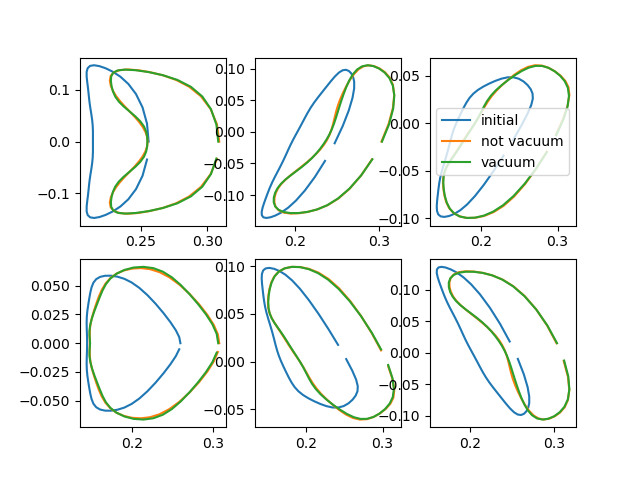

In [7]:
# Plots cross-sections
fig, ax = plt.subplots(2,3)
varr = [initial_vmec] + vmec
leg = ['initial', 'not vacuum', 'vacuum']
for phi, aa in zip(np.linspace(0,np.pi,6,endpoint=False), ax.flatten()):
    for v, l in zip(varr,leg):
        s = v.boundary
        c = s.cross_section(phi=phi)

        R = np.sqrt(c[:,0]**2 + c[:,1]**2)
        Z = c[:,2]

        aa.plot(R,Z,label=l)
ax[0,2].legend()
plt.savefig(os.path.join(figure_path, 'boundary_cross_section.png'))

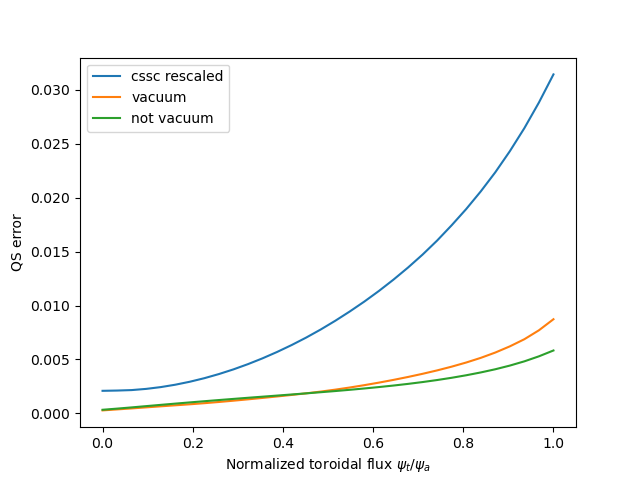

In [8]:
quasisymmetry_target_surfaces = np.linspace(0,1,32,endpoint=True)
plt.figure()
leg = ['cssc rescaled', 'vacuum', 'not vacuum']
for v, l in zip(varr,leg):
    qs = QuasisymmetryRatioResidual(v, quasisymmetry_target_surfaces, helicity_m=1, helicity_n=0)
    plt.plot(quasisymmetry_target_surfaces, qs.profile(), label=l)
plt.legend()
plt.xlabel(r'Normalized toroidal flux $\psi_t/\psi_a$')
plt.ylabel('QS error')

plt.savefig(os.path.join(figure_path, 'qs_profile.png'))

'float' object has no attribute 'reshape'
'float' object has no attribute 'reshape'
'float' object has no attribute 'reshape'


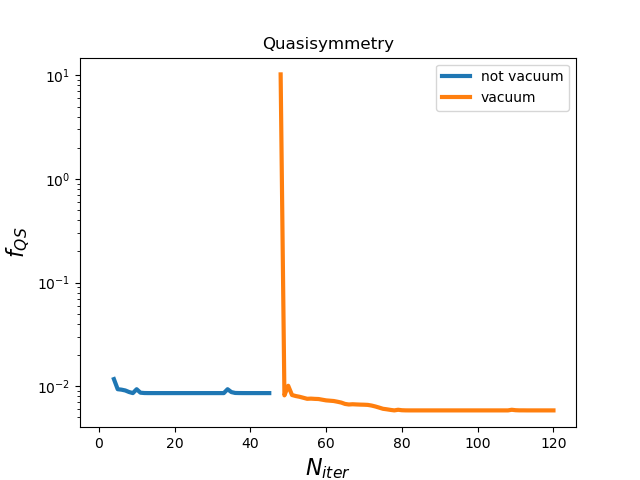

In [9]:
outputs = []
inputs = []
for tp in this_path:
    with open(os.path.join(tp, 'outputs.pckl'), 'rb') as f:
        outputs.append(pickle.load(f))
    with open(os.path.join(tp, 'input.pckl'), 'rb') as f:
        inputs.append(pickle.load(f))

total = []
step = []
nphi = 64
ntheta = 63
counter = 0
for jj, (inp, oup) in enumerate(zip(inputs, outputs)):
    total.append([])
    step.append([])
    nsteps = len(oup['mean_iota'])
    ns = inp['vmec']['target']['qa_surface'].size
    for ii, qs in enumerate(oup['QSresiduals']):
        counter +=1
        try:
            residuals3d = qs.reshape((ns,ntheta,nphi))
            total[jj].append(np.sum(qs * qs))
        except BaseException as e:
            print(e)
            total[jj].append(np.nan)
        step[jj].append(counter)
            
fig, ax = plt.subplots()
for s, t in zip(step, total):
    ax.semilogy(s,t, label='total', linewidth=3)
ax.legend({'not vacuum', 'vacuum'})
ax.set_title('Quasisymmetry')
ax.set_ylabel(r'$f_{QS}$',fontsize=16)
ax.set_xlabel(r'$N_{iter}$',fontsize=16)
plt.savefig(os.path.join(figure_path, 'quasisymmetry.png'))